## Numeryczne Rozwiązywanie Rónań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ



# Metoda różnic skończonych

## Laboratorium I
### Równanie eliptyczne

$$ u_{xx}  + u_{yy} = -2 \pi^2 \sin(\pi x) \sin(\pi y)$$

$$ u_{| \partial{D}} = 0 $$

$$ D = \{(x, y) \in R^2 : x, y \in (0, 1) \} $$

Rozwiązanie dokładne: $$ u(x, y) = \sin(\pi x) \sin(\pi y) $$

In [11]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg

from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Optional

In [12]:
class SetupElliptic:
    def __init__(self, 
                 dx: float, 
                 dy: Optional[float] = None,
                 x_range = (0,1), 
                 y_range = (0,1),
                 f = lambda x, y: 0,
                 boundary_right = lambda y: 0,
                 boundary_up = lambda x: 0,
                 boundary_left = lambda y: 0,
                 boundary_down = lambda x: 0
                ):
        
        dy = dy or dx
        self.x_range = x_range
        self.y_range = y_range
        self.boundary_left = boundary_left
        self.boundary_right = boundary_right
        self.boundary_up = boundary_up
        self.boundary_down = boundary_down        

        self.f = f
        self.x_num = round((self.x_range[1] - self.x_range[0]) / dx) + 1
        self.y_num = round((self.y_range[1] - self.y_range[0]) / dy) + 1
        self.X, self.dx = np.linspace(*self.x_range, self.x_num, retstep=True)
        self.Y, self.dy = np.linspace(*self.y_range, self.y_num, retstep=True)

In [13]:
def laplacian_matrix(dx, dy, x_num, y_num):
    size = x_num*y_num
    ones = np.ones(size)
    Ly = scipy.sparse.dia_matrix(([ones, -2*ones, ones], [-1,0,1]), shape=(y_num, y_num))
    My = (1/dy ** 2) * scipy.sparse.block_diag([Ly]*x_num)
    I = np.identity(y_num)
    Mx_data = [ [None]*(x_num) for i in range(x_num)]
    Mx_data[0][0] = -2*I
    for i in range(1, x_num):
        Mx_data[i][i] = -2*I
        Mx_data[i-1][i] = I
        Mx_data[i][i-1] = I
    Mx = (1/dx ** 2) * scipy.sparse.bmat(Mx_data)
    return Mx + My
    
def scheme_elliptic(setup):
    ret = np.zeros((setup.x_num,setup.y_num))
    ret[0,:] = np.array([setup.boundary_left(setup.Y[j]) for j in range(setup.y_num)])
    ret[-1,:] = np.array([setup.boundary_right(setup.Y[j]) for j in range(setup.y_num)])
    ret[:,0] = np.array([setup.boundary_down(setup.X[i]) for i in range(setup.x_num)])
    ret[:,-1] = np.array([setup.boundary_up(setup.X[i]) for i in range(setup.x_num)])
    
    size = (setup.x_num-2)*(setup.y_num-2)
    r = np.zeros((setup.x_num-2,setup.y_num-2))
    
    r[0,:] = (-1/setup.dy**2)*ret[0,1:-1]
    r[-1,:] = (-1/setup.dy**2)*ret[-1,1:-1]
    r[:,0] = (-1/setup.dx**2)*ret[1:-1,0]
    r[:,-1] = (-1/setup.dx**2)*ret[1:-1,-1]

    f = np.array([[setup.f(setup.X[i], setup.Y[j]) for j in range(1,setup.y_num-1)] for i in range(1,setup.x_num-1)])
    rhs = (r + f).reshape(size, order='C')
    
    # Macierz
    M = laplacian_matrix(setup.dx, setup.dy, setup.x_num-2, setup.y_num-2)
    ret[1:-1,1:-1] = scipy.sparse.linalg.spsolve(M, rhs).reshape(setup.x_num-2, setup.y_num-2)
    return ret.T

In [14]:
def plot_surface(u, setup):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(setup.X, setup.Y)
    surf = ax.plot_surface(X, Y, u, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [15]:
%%time
# numerical solution
setup_elliptic = SetupElliptic(
    dx=0.01, 
    dy=0.01,
    x_range=(0.0, 1.0),
    y_range=(0.0, 1.0),
    f=lambda x,y: (-2)*(np.pi ** 2)*np.sin(np.pi*x)*np.sin(np.pi*y),
    boundary_right = lambda y: 0, # boundary right (x=1)
    boundary_up = lambda x: 0, # boundary up    (y=1)
    boundary_left = lambda y: 0, # boundary left  (x=0)
    boundary_down = lambda x: 0  # boundary down  (y=0)
)

#setup_elliptic = SetupElliptic(0.01)
numerical_elliptic = scheme_elliptic(setup_elliptic)

# exact solution
m_X, m_Y = np.meshgrid(setup_elliptic.X,setup_elliptic.Y)
exact_elliptic = np.sin(np.pi * m_X) * np.sin(np.pi * m_Y)

CPU times: user 168 ms, sys: 25.8 ms, total: 194 ms
Wall time: 175 ms


**Rozwiązanie numeryczne**

<IPython.core.display.Javascript object>

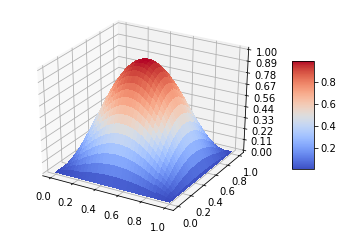

In [16]:
plot_surface(numerical_elliptic, setup_elliptic)

**Rozwiązanie dokładne**

<IPython.core.display.Javascript object>

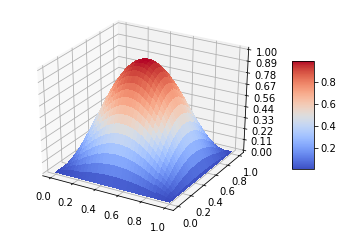

In [17]:
plot_surface(exact_elliptic, setup_elliptic)

**Błąd**

<IPython.core.display.Javascript object>

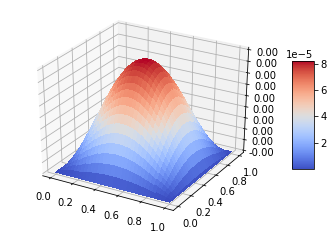

In [18]:
plot_surface(numerical_elliptic - exact_elliptic, setup_elliptic)

In [19]:
import time

steps = [.1, .05, .01, .005]
times = []
errors = []

for h in steps:
    setup_elliptic = SetupElliptic(
        dx=h, 
        dy=h,
        x_range=(0.0, 1.0),
        y_range=(0.0, 1.0),
        f=lambda x,y: (-2)*(np.pi ** 2)*np.sin(np.pi*x)*np.sin(np.pi*y),
        boundary_right = lambda y: 0, # boundary right (x=1)
        boundary_up = lambda x: 0, # boundary up    (y=1)
        boundary_left = lambda y: 0, # boundary left  (x=0)
        boundary_down = lambda x: 0  # boundary down  (y=0)
    )
    time_start = time.time()
    numerical_elliptic = scheme_elliptic(setup_elliptic)
    time_diff = time.time() - time_start
    times.append(time_diff)

    # exact solution
    m_X, m_Y = np.meshgrid(setup_elliptic.X,setup_elliptic.Y)
    exact_elliptic = np.sin(np.pi * m_X) * np.sin(np.pi * m_Y)
    error = numerical_elliptic - exact_elliptic
    abs_err = abs(max(error.min(), error.max(), key=abs))
    errors.append(abs_err)

print("steps=",steps)
print("times=",times)
print("errors=",errors)

steps= [0.1, 0.05, 0.01, 0.005]
times= [0.007987737655639648, 0.009480714797973633, 0.17708110809326172, 1.0670759677886963]
errors= [0.008265416966228623, 0.002058706764533458, 8.225076216028526e-05, 2.0561929256368572e-05]
